In [1]:
import torch
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error

from torch.autograd import Variable
import random

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader

In [2]:
print('GPU availability:', torch.cuda.is_available())

GPU availability: True


In [3]:
class prediction_model(nn.Module):

    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(prediction_model, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden1_size)
        # self.dropout1 = nn.Dropout(p=0.1)
        self.batch1 = nn.BatchNorm1d(hidden1_size)

        self.hidden2 = nn.Linear(hidden1_size, hidden2_size)
        self.dropout2 = nn.Dropout(p=0.01)
        self.batch2 = nn.BatchNorm1d(hidden2_size)

        # self.hidden3 = nn.Linear(hidden2_size, hidden3_size)
        # self.batch3 = nn.BatchNorm1d(hidden3_size)

        self.predict = nn.Linear(hidden2_size, output_size)
    
    def forward(self, input):
        result = self.hidden1(input)
        # result = self.dropout1(result)
        result = self.batch1(result)
        result = F.leaky_relu(result)

        result = self.hidden2(result)
        result = self.dropout2(result)
        result = self.batch2(result)
        result = F.leaky_relu(result)

        # result = self.hidden3(result)
        # result = self.batch3(result)
        # result = F.leaky_relu(result)

        result = self.predict(result)

        return result

In [4]:
def train(model, x_data, y_data, optimizer, loss, epochs, device):

    final_R2_train = []
    final_R2_test = []
    final_rmse_train = []
    final_rmse_test = []


    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 64)

    # kf = KFold(n_splits = 3, shuffle=True, random_state=42)

    # for train_index, val_index in kf.split(x_train):

        # x_train_1, x_test_1 = x_train[train_index], x_train[val_index]
        # y_train_1, y_test_1 = y_train[train_index], y_train[val_index]

    x_train_tensor = torch.tensor(x_train, dtype=torch.float32).cuda()
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).cuda()
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).cuda()
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).cuda()

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


    for epoch in range(epochs):
        model.train()

        mse_loss = []
        # define batch: batch_sizee = 100
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()   # initialize gradient, gradient computed from batch 1 does not interfere batch2 and model update

            output = model(batch_x)
            l = loss(output, batch_y)

            mse_loss.append(l.item())   # l.item() 返回tensor中的每一个值，节约内存

            l.backward()     # back propagation
            optimizer.step()    # update model
        
        
        if epoch % 5 == 0:
            with torch.no_grad():
                model.eval()
                train_pred = model(batch_x.to(device)).cpu().numpy().flatten()
                r2_train = r2_score(batch_y, train_pred)
                rmse_train = np.sqrt(mean_squared_error(batch_y, train_pred))

                final_R2_train.append(r2_train)
                final_rmse_train.append(rmse_train)

                # final_R2_test.append()
                print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {np.mean(mse_loss)}, R2 Score (Train): {r2_train}, RMSE (Train): {rmse_train}")

                test_loss = []
                test_preds_list = []
                test_target_list = []
                for batch_x, batch_y in test_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    test_output = model(batch_x)
                    l = loss(test_output, batch_y)
                    test_loss.append(l.item())

                    test_preds_list.append(test_output.cpu().numpy())
                    test_target_list.append(batch_y.cpu().numpy())
                    
                test_preds = np.concatenate(test_preds_list).flatten()
                test_target = np.concatenate(test_target_list).flatten()

                r2_test = r2_score(test_target, test_preds)
                rmse_test = np.sqrt(mean_squared_error(test_target, test_preds))

                final_R2_test.append(r2_test)
                final_rmse_test.append(rmse_test)

                print(f"Test Loss: {np.mean(test_loss)}, R2 Score (Test): {r2_test}, RMSE (Test): {rmse_test}")

    return final_R2_test, final_R2_train, final_rmse_test, final_rmse_train

In [5]:
x_data_DB = pd.read_csv('./Data_BindingDB/x_value_train.csv')
x_data_DB = x_data_DB.values
x_data_DB

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
y_data_DB = pd.read_csv('./Data_BindingDB/y_value_train.csv')
y_data_DB = y_data_DB.values
# y_data

In [7]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device', device)
model = prediction_model(x_data_DB.shape[1], 512, 512, 1)
loss_func = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-5)

model = model.to(device)
loss = loss_func.to(device)
epochs = 3000


final_R2_test, final_R2_train, final_rmse_test, final_rmse_train = train(model, x_data_DB, y_data_DB, optimizer, loss, epochs, device)

# for plot
final_R2_train = final_R2_train[5:]
final_R2_test = final_R2_test[5:]
final_rmse_train = final_rmse_train[5:]
final_rmse_test = final_rmse_test[5:]

# for calculation
print('=========================================')
final_R2_train_sub = final_R2_train[200:]
final_R2_test_sub = final_R2_test[200:]
final_rmse_train_sub = final_rmse_train[200:]
final_rmse_test_sub = final_rmse_test[200:]
print(f'average R2 on training dataset:{np.mean(final_R2_train_sub)}, average R2 on testing dataset:{np.mean(final_R2_test_sub)}')
print(f'average rmse on training dataset:{np.mean(final_rmse_train_sub)}, average rmse on testing dataset:{np.mean(final_rmse_test_sub)}')

Using device cuda
Epoch [1/3000], Train Loss: 53.37324364980062, R2 Score (Train): -369.93638579576105, RMSE (Train): 7.063467979431152
Test Loss: 52.64941279093424, R2 Score (Test): -27.886153283186083, RMSE (Test): 7.258529186248779
Epoch [6/3000], Train Loss: 32.9300332069397, R2 Score (Train): -158.3229438924435, RMSE (Train): 5.801379203796387
Test Loss: 34.232940673828125, R2 Score (Test): -17.774101209889082, RMSE (Test): 5.851717472076416
Epoch [11/3000], Train Loss: 20.463254769643147, R2 Score (Train): -74.05537943585834, RMSE (Train): 4.748501300811768
Test Loss: 23.05213801066081, R2 Score (Test): -11.657277111069428, RMSE (Test): 4.804784774780273
Epoch [16/3000], Train Loss: 10.844873269399008, R2 Score (Train): -133.6254329461443, RMSE (Train): 2.9966611862182617
Test Loss: 14.097466786702475, R2 Score (Test): -6.750513832779631, RMSE (Test): 3.7598369121551514
Epoch [21/3000], Train Loss: 6.739940365155538, R2 Score (Train): -34.36129613883881, RMSE (Train): 3.232165575

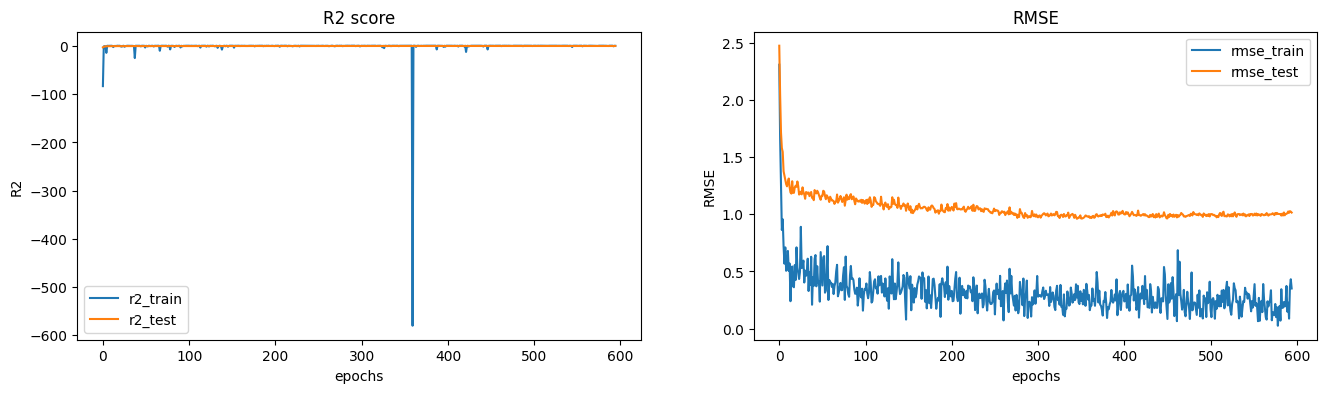

In [8]:
x = [i for i in range(595)]
fig = plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(x, final_R2_train, label = 'r2_train')
plt.plot(x, final_R2_test, label = 'r2_test')
plt.legend()
plt.title('R2 score')
plt.xlabel('epochs')
plt.ylabel('R2')

plt.subplot(1, 2, 2)
plt.plot(x, final_rmse_train, label = 'rmse_train')
plt.plot(x, final_rmse_test, label = 'rmse_test')
plt.legend()
plt.title('RMSE')
plt.xlabel('epochs')
plt.ylabel('RMSE')

plt.show()

In [9]:
x_chembl = pd.read_csv('./Data/x_value_train.csv')
x_chembl = x_chembl.values
# x_chembl



In [10]:


y_chembl = pd.read_csv('./Data/y_value_train.csv')
y_chembl = y_chembl.values
# y_chembl

In [11]:
final_R2_train = []
final_R2_test = []
final_rmse_train = []
final_rmse_test = []

epochs = 1500
final_R2_test, final_R2_train, final_rmse_test, final_rmse_train = train(model, x_chembl, y_chembl, optimizer, loss, epochs, device)

# for plot
final_R2_train = final_R2_train[0:]
final_R2_test = final_R2_test[0:]
final_rmse_train = final_rmse_train[0:]
final_rmse_test = final_rmse_test[0:]

# for calculation
print('=========================================')
final_R2_train_sub = final_R2_train[0:]
final_R2_test_sub = final_R2_test[0:]
final_rmse_train_sub = final_rmse_train[0:]
final_rmse_test_sub = final_rmse_test[0:]
print(f'average R2 on training dataset:{np.mean(final_R2_train_sub)}, average R2 on testing dataset:{np.mean(final_R2_test_sub)}')
print(f'average rmse on training dataset:{np.mean(final_rmse_train_sub)}, average rmse on testing dataset:{np.mean(final_rmse_test_sub)}')

Epoch [1/1500], Train Loss: 0.8943074544270834, R2 Score (Train): 0.8112528457634797, RMSE (Train): 0.7075579762458801
Test Loss: 0.8312903940677643, R2 Score (Test): 0.6717301129470533, RMSE (Test): 0.8987038135528564
Epoch [6/1500], Train Loss: 0.22796277701854706, R2 Score (Train): 0.9171769306182476, RMSE (Train): 0.4676348567008972
Test Loss: 0.44528715312480927, R2 Score (Test): 0.8340639449650696, RMSE (Test): 0.6389567255973816
Epoch [11/1500], Train Loss: 0.16433444991707802, R2 Score (Train): 0.9715372910571093, RMSE (Train): 0.293902188539505
Test Loss: 0.4240540415048599, R2 Score (Test): 0.8414768101489494, RMSE (Test): 0.6245215535163879
Epoch [16/1500], Train Loss: 0.07733817150195439, R2 Score (Train): 0.9765181977739549, RMSE (Train): 0.2473943829536438
Test Loss: 0.425907701253891, R2 Score (Test): 0.8420116499537715, RMSE (Test): 0.623467206954956
Epoch [21/1500], Train Loss: 0.07364896560708682, R2 Score (Train): 0.9877198248548125, RMSE (Train): 0.1904558539390564


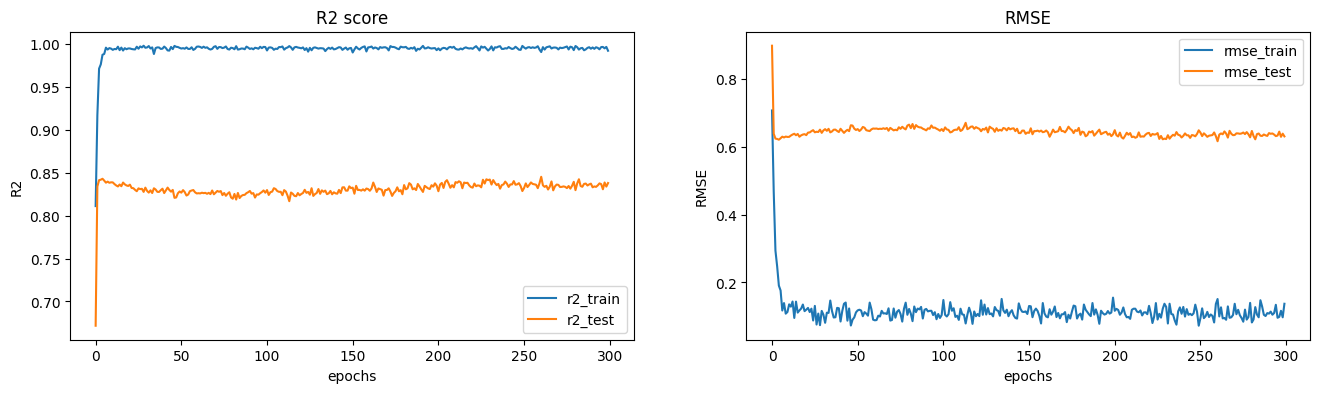

In [12]:
x = [i for i in range(300)]
fig = plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(x, final_R2_train, label = 'r2_train')
plt.plot(x, final_R2_test, label = 'r2_test')
plt.legend()
plt.title('R2 score')
plt.xlabel('epochs')
plt.ylabel('R2')

plt.subplot(1, 2, 2)
plt.plot(x, final_rmse_train, label = 'rmse_train')
plt.plot(x, final_rmse_test, label = 'rmse_test')
plt.legend()
plt.title('RMSE')
plt.xlabel('epochs')
plt.ylabel('RMSE')

plt.show()

In [14]:
# torch.save(model, './model/ANN_model_transfer_learning.pth')